In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=6, suppress=True)
from sklearn.utils import shuffle

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import *
tf.__version__

'2.3.0'

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (LinearLocator, MultipleLocator, FormatStrFormatter)
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [6]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Hyperparameters

In [7]:
BEST_PATH = './models/convnet.h5'
TRAINING_EPOCHS = 200
LEARNING_RATE = 0.002
EPSILON = 1e-06
BATCH_SIZE = 16

# Data loading

In [8]:
l = np.load('./results/2020_S/fw_dataset.npz', allow_pickle=True)
data_indices = l['data_indices']
input_data = l['input_data']
output_label = l['output_label']
INPUT_MAXS = l['INPUT_MAXS']
INPUT_MINS = l['INPUT_MINS']
OUTPUT_MAX = l['OUTPUT_MAX']
OUTPUT_MIN = l['OUTPUT_MIN']

In [9]:
input_data = input_data.astype('float32')
output_label = output_label.astype('float32')

In [10]:
print(input_data.shape)
print(output_label.shape)

(363, 144, 9)
(363, 1)


In [11]:
print(INPUT_MAXS)
print(INPUT_MINS)

[ 42.31875  90.9425  330.1      73.335    10.006     5.057    36.58
  50.264    19.731  ]
[15.83875  4.4325  -0.5957  32.115    2.296    0.579   15.7      8.744
 11.393  ]


In [12]:
print(OUTPUT_MAX)
print(OUTPUT_MIN)

2.470441467376113
0.40038664002968494


In [13]:
data_indices, input_data, output_label = shuffle(data_indices, input_data, output_label, random_state=3101)

In [14]:
N_TRAIN = int(input_data.shape[0]*.8)
train_input = input_data[:N_TRAIN, ...]
train_label = output_label[:N_TRAIN, ...]
train_indices = data_indices[:N_TRAIN]
val_input = input_data[N_TRAIN:, ...]
val_label = output_label[N_TRAIN:, ...]
val_indices = data_indices[N_TRAIN:]

In [15]:
print(f'number of training set: {train_input.shape[0]}')
print(f'number of validation set: {val_input.shape[0]}')

number of training set: 290
number of validation set: 73


In [16]:
with strategy.scope():
    train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
    train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*10).batch(BATCH_SIZE, drop_remainder=False)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_label))
    val_dataset = val_dataset.cache().shuffle(BATCH_SIZE*10).batch(BATCH_SIZE, drop_remainder=False)

# Model construction

In [17]:
class ResNet1D(Model):
    def __init__(self):
        super(ResNet1D, self).__init__()
        self.n = [128, 128, 256, 256, 512] # number of nodes
        self.k = [1, 5, 10, 20, 50] # kernal size
        self.s = 2 # stride (= pooling size)
                
        self.conv1_1 = layers.Conv1D(self.n[0]/4, self.k[0], kernel_initializer='glorot_normal', padding='same')
        self.conv1_2 = layers.Conv1D(self.n[0]/4, self.k[1], kernel_initializer='glorot_normal', padding='same')
        self.conv1_3 = layers.Conv1D(self.n[0]/4, self.k[2], kernel_initializer='glorot_normal', padding='same')
        self.conv1_4 = layers.Conv1D(self.n[0]/4, self.k[3], kernel_initializer='glorot_normal', padding='same')
        self.conv1_5 = layers.Conv1D(self.n[0]/4, self.k[4], kernel_initializer='glorot_normal', padding='same')
        self.batch1 = layers.BatchNormalization()
        self.activation1 = layers.Activation(tf.nn.leaky_relu)
        self.pool1 = layers.MaxPooling1D(2)
        
        self.conv2 = layers.Conv1D(self.n[1], 1, kernel_initializer='glorot_normal', padding='valid')
        self.batch2 = layers.BatchNormalization()
        self.activation2 = layers.Activation(tf.nn.leaky_relu)
        self.pool2 = layers.MaxPooling1D(2)
        
        self.conv3 = layers.Conv1D(self.n[2], 1, kernel_initializer='glorot_normal', padding='valid')
        self.batch3 = layers.BatchNormalization()
        self.activation3 = layers.Activation(tf.nn.leaky_relu)
        self.pool3 = layers.MaxPooling1D(2)
                                          
        self.conv4 = layers.Conv1D(self.n[3], 1, kernel_initializer='glorot_normal', padding='valid')
        self.batch4 = layers.BatchNormalization()
        self.activation4 = layers.Activation(tf.nn.leaky_relu)
        self.pool4 = layers.MaxPooling1D(2)
        
        self.output_conv = layers.Conv1D(self.n[4], 1, kernel_initializer='glorot_normal', padding='valid')
        self.gate = layers.Dense(1, activation=tf.nn.sigmoid)
        
    def call(self, inp):
        
        inp = tf.concat([self.conv1_1(inp), self.conv1_2(inp), self.conv1_3(inp), self.conv1_4(inp), self.conv1_5(inp)], -1)
        inp = self.pool1(self.activation1(self.batch1(inp)))
        
        inp = self.pool2(self.activation2(self.batch2(self.conv2(inp))))
        inp = self.pool3(self.activation3(self.batch3(self.conv3(inp))))
        inp = self.pool4(self.activation4(self.batch4(self.conv4(inp))))
        
        inp = self.gate(self.output_conv(inp))
        
        return inp

In [18]:
callbacks = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=.5, patience=2, verbose=0, mode='min',
    min_delta=0.0001, cooldown=0, min_lr=0)

save = tf.keras.callbacks.ModelCheckpoint(
    BEST_PATH, monitor='val_loss', verbose=0,
    save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20) 

In [19]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    model = ResNet1D()
    model.compile(optimizer=opt, loss='mae')
    model.fit(train_dataset, epochs=TRAINING_EPOCHS, validation_data=val_dataset,
                  verbose=1, callbacks=[callbacks, save, early_stop]) 

Epoch 1/200
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 28 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 28 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
19/19 [==============================] - ETA: 0s - loss: 0.2230INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/repli

In [20]:
model.load_weights(BEST_PATH)

In [21]:
model.evaluate(val_dataset)

5/5 [==============================] - 0s 4ms/step - loss: 0.0326


0.03258232772350311

In [22]:
pred_output = model.predict(val_input)

In [23]:
pred_output = pred_output*(OUTPUT_MAX - OUTPUT_MIN) + OUTPUT_MIN
val_label = val_label*(OUTPUT_MAX - OUTPUT_MIN) + OUTPUT_MIN

ValueError: x and y can be no greater than 2-D, but have shapes (73, 1) and (73, 9, 1)

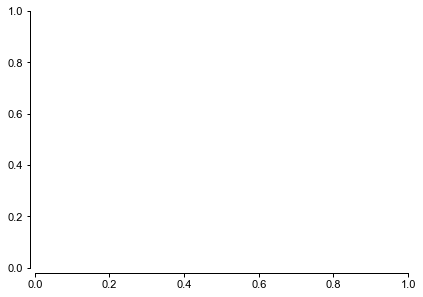

In [24]:
fig = plt.figure(figsize=((8.5/2.54*2), (6/2.54*2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(val_label, pred_output, 'o', ms=5, mec='k', c=cmap[0])


fig.tight_layout()

In [26]:
pred_df = pd.DataFrame(val_label, index=val_indices[:, 0], columns=['label'])
pred_df['pred'] = pred_output
pred_df.index = pd.DatetimeIndex(pred_df.index)
pred_df = pred_df.sort_index()

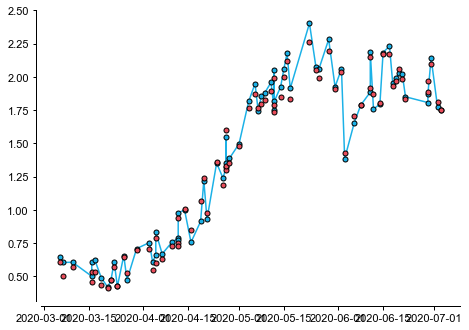

In [27]:
fig = plt.figure(figsize=((8.5/2.54*2), (6/2.54*2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(pred_df.index, pred_df['label'], '-o', ms=5, mec='k', c=cmap[4])
ax0.plot(pred_df.index, pred_df['pred'], 'o', ms=5, mec='k', c=cmap[0])


fig.tight_layout()

In [31]:
pred_df.to_csv('./results/model_output/ffnn_fw.csv')